# DATA 612 Project 4 - Accuracy and Beyond

By Mike Silva

## Introduction

This project has two main components.  The first is to assess the accuracy of the recommender system.  Two different algorithms will be evaluated against offline data.

The second component will be an implementation of the goal of increased serendipity, novelty or diversity.  Once this is implemented, I will reevaluate the accuracy of the recommendations.

### About the Book-Crossing Data

The [Book-Crossing data](http://www2.informatik.uni-freiburg.de/~cziegler/BX/) was collected by Cai-Nicolas Ziegler in a 4-week crawl (August / September 2004) from the Book-Crossing community with kind permission from Ron Hornbaker, CTO of Humankind Systems. It contains 278,858 users (anonymized but with some demographic information) and 1,149,780 ratings (explicit & implicit) about 271,379 books.


## Data Acquisition and Exploration

In [1]:
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
import os
import random
import numpy as np
import pandas as pd
import requests
import zipfile
import seaborn as sns
# I will be using the surprise package to build my recommender system
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import KFold, cross_validate
from surprise import SVD, SVDpp, NMF
from surprise import accuracy

# Make this repeatable
my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)

%matplotlib inline

# STEP 1 - DOWNLOAD THE DATA SET
if not os.path.exists("BX-CSV-Dump.zip"):
    # We need to download it
    response = requests.get("http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip")
    if response.status_code == 200:
        with open("BX-CSV-Dump.zip", "wb") as f:
            f.write(response.content)
# STEP 2 - EXTRACT THE DATA SET
if not os.path.exists("BX-Book-Ratings.csv"):
    with zipfile.ZipFile("BX-CSV-Dump.zip","r") as z:
        z.extractall()
# STEP 3 - READ IN THE DATA
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding = "unicode_escape") 

users = pd.read_csv("BX-Users.csv", sep=";", encoding = "unicode_escape") 

# Had to do this the old fashioned way
items = []

with open("BX-Books.csv") as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    for row in reader:
        items.append(row)
        
items = pd.DataFrame(items)
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


I'm going to simplify the data by converting the ISBN and User ID to an index number.  This will be a bit easier to work with than an ISBN

In [2]:
item_index = pd.DataFrame({"ISBN": ratings["ISBN"].unique()}).reset_index().rename(columns={"index": "book_id"})
user_index = pd.DataFrame({"User-ID": ratings["User-ID"].unique()}).reset_index().rename(columns={"index": "user_id"})
ratings = pd.merge(ratings, item_index).drop(columns=["ISBN"])
ratings = pd.merge(ratings, user_index).drop(columns=["User-ID"]).rename(columns={"Book-Rating": "rating"})
ratings = ratings[["book_id", "user_id", "rating"]]
ratings

,book_id,user_id,rating
0,0,0,0
1,0,1655,5
2,383,1655,9
3,443,1655,8
4,1313,1655,9
...,...,...,...
1149775,340494,105254,10
1149776,340500,105260,8
1149777,340501,105261,5
1149778,340510,105264,8


There is over one million records here which will be a problem on my computer.  Let's get a quick tally of how many of each ratings are in this data set:

In [3]:
ratings.groupby("rating")["rating"].count()

rating
0     716109
1       1770
2       2759
3       5996
4       8904
5      50974
6      36924
7      76457
8     103736
9      67541
10     78610
Name: rating, dtype: int64

Well over 700K are zeros.  The documentation indicates they are implicit ratings.  Let's visualize the non-zero (explicit) ratings.

In [4]:
non_zero_ratings = ratings[ratings["rating"] > 0].reset_index(drop=True)
len(non_zero_ratings.index)

433671

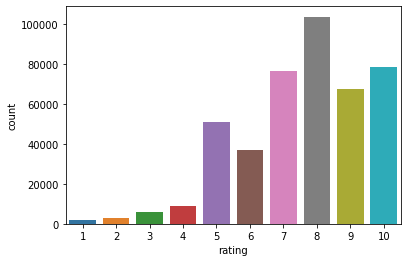

In [5]:
sns.countplot(x="rating", data=non_zero_ratings)

There's quite a few books that received an 8+ rating.  That may be what I will call the "good" recommendations.  Let's see what the average rating is for the non-zero rated books:

In [6]:
average_non_zero_rating = non_zero_ratings["rating"].mean()
average_non_zero_rating

7.601066246071331

I will use 8+ as they have a higher than average rating.  Seven or lower are not desirable recommendations. 

## Recommender System Development

I will develop a SVD recommender system.  Due to the quantity of ratings, an the limits of my computer, I am not able to implement a collaborative filter.  However I can preform a couple of matrix factorization based systems: [non-negative matrix factorization](https://medium.com/logicai/non-negative-matrix-factorization-for-recommendation-systems-985ca8d5c16c) (NMF) and SVD++.

I will also try to increase the diversity of the recommendations.  To do this I will select a sub-group of users that have the most ratings to train the model.  I am working under the assumption that by using the users who have reviewed a diverse set of books at the basis of the training data, the recommender system will produce more diverse recommendations.

For this project I will be utilizing the [Suprise python package](http://surpriselib.com/) to aid in building the recommendation systems.  This package was able to handle the large amount of data.  I will first create my diverse data set by taking the explicit ratings and subsetting the data.

In [7]:
diverse_user_set = non_zero_ratings.groupby(['user_id']).agg({'book_id': 'count'}).reset_index().rename(columns={"book_id": "Reviews"}).sort_values("Reviews", ascending=False).head(50)['user_id'].to_list()
diverse_ratings = pd.merge(ratings, pd.DataFrame({"user_id": diverse_user_set}))
len(diverse_ratings.index)

89247

This leave just under 90,000 ratings for training the recommender system, down from  965,000.  I will set up the data sets to work with the Surprise package.

In [8]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(non_zero_ratings, reader)
diverse = Dataset.load_from_df(diverse_ratings, reader)

Now that I have the data set I will train a SVD model on the full diverse set to be the model that offers diverse recommendations.  I will then preform K-Fold validation of the model by training other models and measuring the accuracy in terms of RMSE and MAE on the test set.  I will also gather the precision and recall for the various models using the source code provided in the [Surprise documentation](https://surprise.readthedocs.io/en/stable/FAQ.html) with minor alterations by me.  

In order to evaluate the level of diversity of the recommendations, 

In [9]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


def get_item_coverage(predictions, n=10, threshold = 8):
    top_n = get_top_n(predictions, n)
    items_recommended = set()
    for user, items in top_n.items():
        for item, rating in items:
            if round(rating, 0) >= threshold:
                items_recommended.add(item)

    return len(items_recommended)

diverse_ratings_N = diverse_ratings.nunique(axis = 0, dropna = True)["book_id"]
ratings_N = non_zero_ratings.nunique(axis = 0, dropna = True)["book_id"]

kf = KFold(n_splits=5)
svd = SVD()
diverse_svd = SVD()
diverse_svd.fit(diverse.build_full_trainset())
svdpp = SVDpp()
nmf = NMF()

results = list()
precision_and_recall = list()

fold = 0
for training_set, test_set in kf.split(data):
    fold += 1
    print("Working through K-Fold #" + str(fold))
    # Train the models on the training set
    print(" Training models...")
    svd.fit(training_set)
    svdpp.fit(training_set)
    nmf.fit(training_set)
    # Remember diverse_svd was already trained on the full diverse training set
    
    # Get the predictions on the test set
    print(" Predicting test set...")
    svd_predictions = svd.test(test_set)
    svdpp_predictions = svdpp.test(test_set)
    nmf_predictions = nmf.test(test_set)
    diverse_svd_predictions = diverse_svd.test(test_set)
    
    # Compute the coverage of the top 10 "good" predictions
    print(" Getting the coverage of the predictions...")
    svd_predictions_coverage = (get_item_coverage(svd_predictions) / ratings_N) * 100
    svdpp_predictions_coverage = (get_item_coverage(svdpp_predictions) / ratings_N) * 100
    nmf_predictions_coverage = (get_item_coverage(nmf_predictions) / ratings_N) * 100
    diverse_svd_predictions_coverage = (get_item_coverage(diverse_svd_predictions) / diverse_ratings_N) * 100
            
    # Compute the RMSEs
    print(" Evaluating accuracy...")
    results.append({"Algorithm":"SVD", "K-Fold": fold, "Coverage": svd_predictions_coverage, "RMSE": accuracy.rmse(svd_predictions, verbose=False), "MAE": accuracy.mae(svd_predictions, verbose=False)})
    results.append({"Algorithm":"SVD++", "K-Fold": fold, "Coverage": svdpp_predictions_coverage, "RMSE": accuracy.rmse(svdpp_predictions, verbose=False), "MAE": accuracy.mae(svdpp_predictions, verbose=False)})
    results.append({"Algorithm":"NMF", "K-Fold": fold, "Coverage": nmf_predictions_coverage, "RMSE": accuracy.rmse(nmf_predictions, verbose=False), "MAE": accuracy.mae(nmf_predictions, verbose=False)})
    results.append({"Algorithm":"Diverse SVD", "K-Fold": fold, "Coverage": diverse_svd_predictions_coverage, "RMSE": accuracy.rmse(diverse_svd_predictions, verbose=False), "MAE": accuracy.mae(diverse_svd_predictions, verbose=False)})
    
    

Working through K-Fold #1
 Training models...
 Predicting test set...
 Getting the coverage of the predictions...
 Evaluating accuracy...
Working through K-Fold #2
 Training models...
 Predicting test set...
 Getting the coverage of the predictions...
 Evaluating accuracy...
Working through K-Fold #3
 Training models...
 Predicting test set...
 Getting the coverage of the predictions...
 Evaluating accuracy...
Working through K-Fold #4
 Training models...
 Predicting test set...
 Getting the coverage of the predictions...
 Evaluating accuracy...
Working through K-Fold #5
 Training models...
 Predicting test set...
 Getting the coverage of the predictions...
 Evaluating accuracy...


In [10]:
results = pd.DataFrame(results)
results

,Algorithm,K-Fold,Coverage,RMSE,MAE
0,SVD,1,10.374087,1.636041,1.262913
1,SVD++,1,10.209547,1.659081,1.288650
2,NMF,1,10.331070,2.447826,2.030095
3,Diverse SVD,1,0.073408,3.840451,3.339021
4,SVD,2,10.328919,1.641852,1.266390
5,SVD++,2,10.232130,1.672420,1.299062
6,NMF,2,10.317089,2.455121,2.037910
7,Diverse SVD,2,0.071910,3.840242,3.332777
8,SVD,3,10.320315,1.631889,1.259990
9,SVD++,3,10.192340,1.659791,1.290163


4. As part of your textual conclusion, discuss one or more additional experiments that
could be performed and/or metrics that could be evaluated only if online evaluation
was possible. Also, briefly propose how you would design a reasonable online
evaluation environment. 